# KSWGD on 2D Chessboard Distribution

This notebook applies **Kernel Stein/Wasserstein Gradient Descent (KSWGD)** to transport particles from a uniform distribution over $[-2,2]^2$ to a **chessboard target density**.

## Problem Setup

- **Domain**: $[-2, 2] \times [-2, 2]$
- **Grid**: $4 \times 4$ unit squares (16 cells total, each $1 \times 1$)
- **Target density**: Uniform on 8 "gray" squares (chessboard pattern), zero on 8 "white" squares
- **Initial distribution**: Uniform over the full domain $[-2,2]^2$
- **Goal**: KSWGD transports particles from uniform → chessboard target

## Algorithm (DMPS-style KSWGD)

1. Sample target points $X_{\text{tar}}$ uniformly from the 8 gray squares
2. Build a Gaussian kernel matrix $K$ on $X_{\text{tar}}$
3. Normalize: density estimation $p(x) = \sum_j K(x, x_j)$, then $\tilde{K} = K / (\sqrt{p} \sqrt{p}^T)$
4. Symmetric random-walk normalization → eigendecomposition → spectral weights
5. Initialize particles uniformly in $[-2,2]^2$
6. Iterate KSWGD: $x^{(t+1)} = x^{(t)} - \frac{h}{m} \sum \nabla K \cdot \phi \Lambda^{-1} \phi^T K$
7. Reflect particles at domain boundaries $[-2,2]^2$

In [20]:
# Import libraries and configure GPU/CPU backend
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import time
import warnings

# Attempt GPU backend
USE_GPU = True
try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="CUDA path could not be detected")
        import cupy as cp
    GPU_AVAILABLE = True
except Exception:
    cp = None
    GPU_AVAILABLE = False

USE_GPU = bool(USE_GPU and GPU_AVAILABLE)
if USE_GPU:
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 120

print(f"Backend: {'GPU (CuPy)' if USE_GPU else 'CPU (NumPy)'}")

Backend: GPU (CuPy)


## 1. Define Chessboard Target Distribution

The domain $[-2,2]^2$ is divided into a $4 \times 4$ grid of unit squares. A square at grid index $(i,j)$ is **gray** (has density) if $(i+j) \bmod 2 = 0$, and **white** (zero density) otherwise.

In [21]:
# === Configuration ===
n_target = 2000     # number of target sample points
d = 2               # dimension
GRID_SIZE = 4       # 4x4 grid
SPACING = 4.0 / GRID_SIZE  # = 1.0 per cell
DOMAIN_LO, DOMAIN_HI = -2.0, 2.0

# Identify gray squares: (i+j) % 2 == 0
square_bounds = []
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        if (i + j) % 2 == 0:
            x_lo = i * SPACING + DOMAIN_LO
            y_lo = j * SPACING + DOMAIN_LO
            square_bounds.append([x_lo, y_lo, x_lo + SPACING, y_lo + SPACING])

square_bounds = np.array(square_bounds)
num_gray = len(square_bounds)
print(f"Chessboard: {num_gray} gray squares out of {GRID_SIZE**2}")

# Sample uniformly from gray squares
samples_per_square = n_target // num_gray
remainder = n_target - samples_per_square * num_gray
X_tar_list = []
for idx in range(num_gray):
    ns = samples_per_square + (1 if idx < remainder else 0)
    x_lo, y_lo, x_hi, y_hi = square_bounds[idx]
    pts = np.column_stack([
        np.random.uniform(x_lo, x_hi, ns),
        np.random.uniform(y_lo, y_hi, ns)
    ])
    X_tar_list.append(pts)

X_tar = np.vstack(X_tar_list).astype(np.float64)
np.random.shuffle(X_tar)
n = X_tar.shape[0]
print(f"Generated {n} target points on gray squares")
print(f"X_tar range: x=[{X_tar[:,0].min():.3f}, {X_tar[:,0].max():.3f}], y=[{X_tar[:,1].min():.3f}, {X_tar[:,1].max():.3f}]")

Chessboard: 8 gray squares out of 16
Generated 2000 target points on gray squares
X_tar range: x=[-1.995, 2.000], y=[-1.998, 1.998]


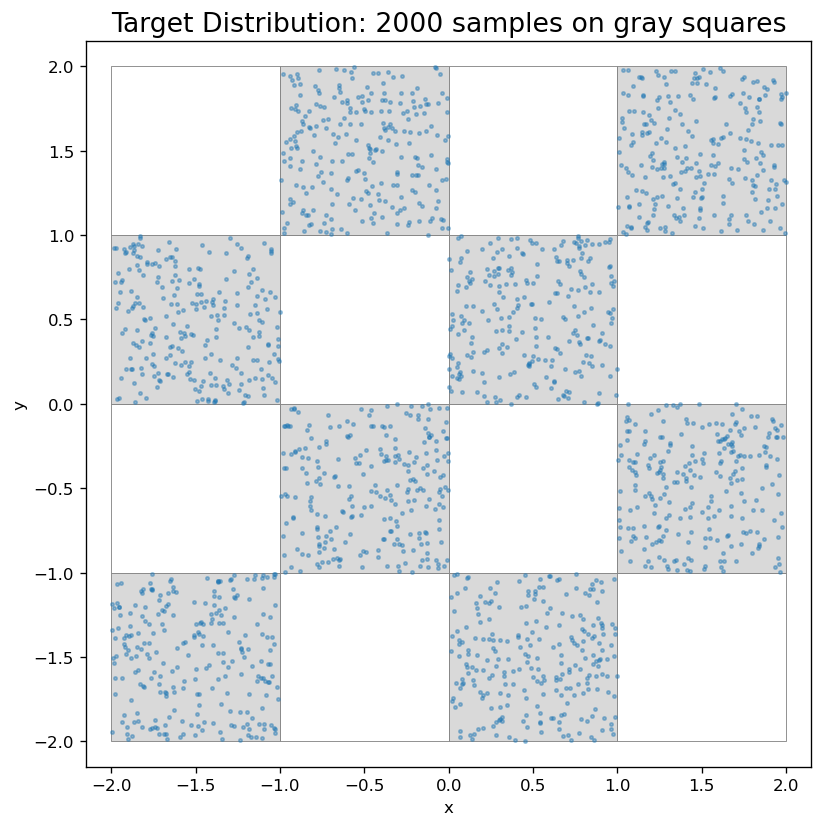

In [22]:
# Visualize target distribution on chessboard
def draw_chessboard(ax, grid_size=4, spacing=1.0, domain_lo=-2.0):
    """Draw chessboard background on given axes."""
    for i in range(grid_size):
        for j in range(grid_size):
            color = '0.85' if (i + j) % 2 == 0 else 'white'
            rect = plt.Rectangle(
                (i * spacing + domain_lo, j * spacing + domain_lo),
                spacing, spacing,
                facecolor=color, edgecolor='gray', linewidth=0.5
            )
            ax.add_patch(rect)
    ax.set_xlim(domain_lo - 0.15, -domain_lo + 0.15)
    ax.set_ylim(domain_lo - 0.15, -domain_lo + 0.15)
    ax.set_aspect('equal')

fig, ax = plt.subplots(figsize=(7, 7))
draw_chessboard(ax)
ax.scatter(X_tar[:, 0], X_tar[:, 1], s=4, c='C0', alpha=0.4, zorder=2)
ax.set_title(f'Target Distribution: {n} samples on gray squares', fontsize=16)
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout()
plt.show()

## 2. Build KSWGD Kernel Operators

Construct the normalized kernel matrix from $X_{\text{tar}}$ and compute the spectral decomposition for KSWGD.

In [23]:
# Compute kernel bandwidth via median heuristic
sq_tar = np.sum(X_tar ** 2, axis=1)
kswgd_dists = pairwise_distances(X_tar, metric='euclidean')
epsilon = np.median(kswgd_dists**2) / (2.0 * np.log(n + 1))
epsilon = float(max(epsilon, 1e-6))
print(f"Kernel bandwidth epsilon = {epsilon:.6f}")
print(f"Distance stats: min={kswgd_dists[kswgd_dists>0].min():.4f}, "
      f"median={np.median(kswgd_dists):.4f}, max={kswgd_dists.max():.4f}")

# Gaussian kernel
data_kernel = np.exp(-kswgd_dists**2 / (2.0 * epsilon))

# DMPS-style density normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)

# Symmetric random-walk normalization
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print(f"Kernel matrix shape: {rw_kernel.shape}")

Kernel bandwidth epsilon = 0.264176
Distance stats: min=0.0013, median=2.0040, max=5.5052
Kernel matrix shape: (2000, 2000)


In [24]:
# Eigendecomposition of normalized kernel
lambda_ns, phi = np.linalg.eigh(rw_kernel)
phi = np.real(phi[:, ::-1])       # descending order
lambda_ns = np.real(lambda_ns[::-1])

# Compute KSWGD spectral weights
tol = 1e-6
reg = 1e-3
lambda_ = 1.0 - lambda_ns          # generator eigenvalues: (1 - lambda_ns) >= 0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= epsilon

lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))

# Truncated quantities for KSWGD
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Density and normalization vectors
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print(f"Retained eigenvectors: {above_tol} / {n}")
print(f"Leading eigenvalues: {lambda_ns[:10].round(6)}")

Retained eigenvectors: 153 / 2000
Leading eigenvalues: [1.000612 0.950658 0.935316 0.917677 0.834117 0.811905 0.742556 0.613343
 0.325571 0.317477]


## 3. KSWGD Particle Transport

Initialize particles **uniformly** in $[-2,2]^2$ and run KSWGD to transport them toward the gray chessboard squares. Reflecting boundary conditions keep particles inside the domain.

In [32]:
# === KSWGD Parameters ===
m_particles = 500    # number of transported particles
num_iters = 500      # number of iterations
step_size = 1.0     # step size h

# Initialize particles uniformly in [-2, 2]^2
x_init = np.random.uniform(DOMAIN_LO, DOMAIN_HI, (m_particles, d))

print(f"Particles: {m_particles}, Iterations: {num_iters}, Step size: {step_size}")
print(f"Target samples: {n}, Dimension: {d}")

Particles: 500, Iterations: 500, Step size: 1.0
Target samples: 2000, Dimension: 2


In [33]:
# === Run KSWGD ===
from tqdm.auto import trange

def reflect_into_domain_np(x, lo=-2.0, hi=2.0):
    """Reflect particles back into [lo, hi]^d (NumPy)."""
    for dim_idx in range(x.shape[1]):
        while np.any(x[:, dim_idx] < lo) or np.any(x[:, dim_idx] > hi):
            x[:, dim_idx] = np.where(x[:, dim_idx] < lo, 2*lo - x[:, dim_idx], x[:, dim_idx])
            x[:, dim_idx] = np.where(x[:, dim_idx] > hi, 2*hi - x[:, dim_idx], x[:, dim_idx])
        x[:, dim_idx] = np.clip(x[:, dim_idx], lo, hi)
    return x

def reflect_into_domain_gpu(x, lo=-2.0, hi=2.0):
    """Reflect particles back into [lo, hi]^d directly on GPU (CuPy)."""
    for dim_idx in range(x.shape[1]):
        for _ in range(10):  # bounded iterations to avoid infinite loop
            x[:, dim_idx] = cp.where(x[:, dim_idx] < lo, 2*lo - x[:, dim_idx], x[:, dim_idx])
            x[:, dim_idx] = cp.where(x[:, dim_idx] > hi, 2*hi - x[:, dim_idx], x[:, dim_idx])
            if cp.all((x[:, dim_idx] >= lo) & (x[:, dim_idx] <= hi)):
                break
        x[:, dim_idx] = cp.clip(x[:, dim_idx], lo, hi)
    return x

# Choose backend
if USE_GPU:
    grad_fn = grad_ker1_gpu
    K_eval_fn = K_tar_eval_gpu
    xp = cp
    X_tar_dev = cp.asarray(X_tar)
    p_tar_dev = cp.asarray(p_tar)
    sq_tar_dev = cp.asarray(sq_tar)
    D_vec_dev = cp.asarray(D_vec)
    phi_trunc_dev = cp.asarray(phi_trunc)
    lambda_ns_s_ns_dev = cp.asarray(lambda_ns_s_ns)
else:
    grad_fn = grad_ker1
    K_eval_fn = K_tar_eval
    xp = np
    X_tar_dev = X_tar
    p_tar_dev = p_tar
    sq_tar_dev = sq_tar
    D_vec_dev = D_vec
    phi_trunc_dev = phi_trunc
    lambda_ns_s_ns_dev = lambda_ns_s_ns

# Storage for particle history (save snapshots to reduce memory)
snapshot_iters = set([0, num_iters//4, num_iters//2, 3*num_iters//4, num_iters-1])
x_snapshots = {}

# Current particle positions
if USE_GPU:
    x_curr = cp.asarray(x_init.copy(), dtype=cp.float64)
else:
    x_curr = x_init.copy().astype(np.float64)

x_snapshots[0] = x_init.copy()

t_start = time.time()
pbar = trange(num_iters - 1, desc="KSWGD", unit="step")

for t in pbar:
    # Compute kernel gradient and cross-kernel
    grad_matrix = grad_fn(x_curr, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, epsilon)
    cross_matrix = K_eval_fn(X_tar_dev, x_curr, p_tar_dev, sq_tar_dev, D_vec_dev, epsilon)
    
    # KSWGD update: phi * diag(lambda_ns_s_ns) * phi^T * cross_matrix
    tmp = phi_trunc_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_dev[:, None] * tmp
    kswgd_push = phi_trunc_dev @ tmp
    
    # Update each dimension
    for dim_idx in range(d):
        sum_term = grad_matrix[:, :, dim_idx] @ kswgd_push
        x_curr[:, dim_idx] = x_curr[:, dim_idx] - (step_size / m_particles) * xp.sum(sum_term, axis=1)
    
    # Reflect into domain (stay on GPU if possible)
    if USE_GPU:
        x_curr = reflect_into_domain_gpu(x_curr, DOMAIN_LO, DOMAIN_HI)
    else:
        x_curr = reflect_into_domain_np(x_curr, DOMAIN_LO, DOMAIN_HI)
    
    # Save snapshot
    if (t + 1) in snapshot_iters:
        if USE_GPU:
            x_snapshots[t + 1] = cp.asnumpy(x_curr).copy()
        else:
            x_snapshots[t + 1] = x_curr.copy()
    
    # Update progress bar with step displacement
    if (t + 1) % 25 == 0 or (t + 1) == num_iters - 1:
        elapsed = time.time() - t_start
        pbar.set_postfix({"elapsed": f"{elapsed:.0f}s"})

# Final particles
if USE_GPU:
    x_final = cp.asnumpy(x_curr)
else:
    x_final = x_curr.copy()

x_snapshots[num_iters - 1] = x_final.copy()
total_time = time.time() - t_start
print(f"\nKSWGD completed in {total_time:.1f}s")

KSWGD: 100%|██████████| 499/499 [00:06<00:00, 76.91step/s, elapsed=6s]


KSWGD completed in 6.5s


## 4. Visualize Results

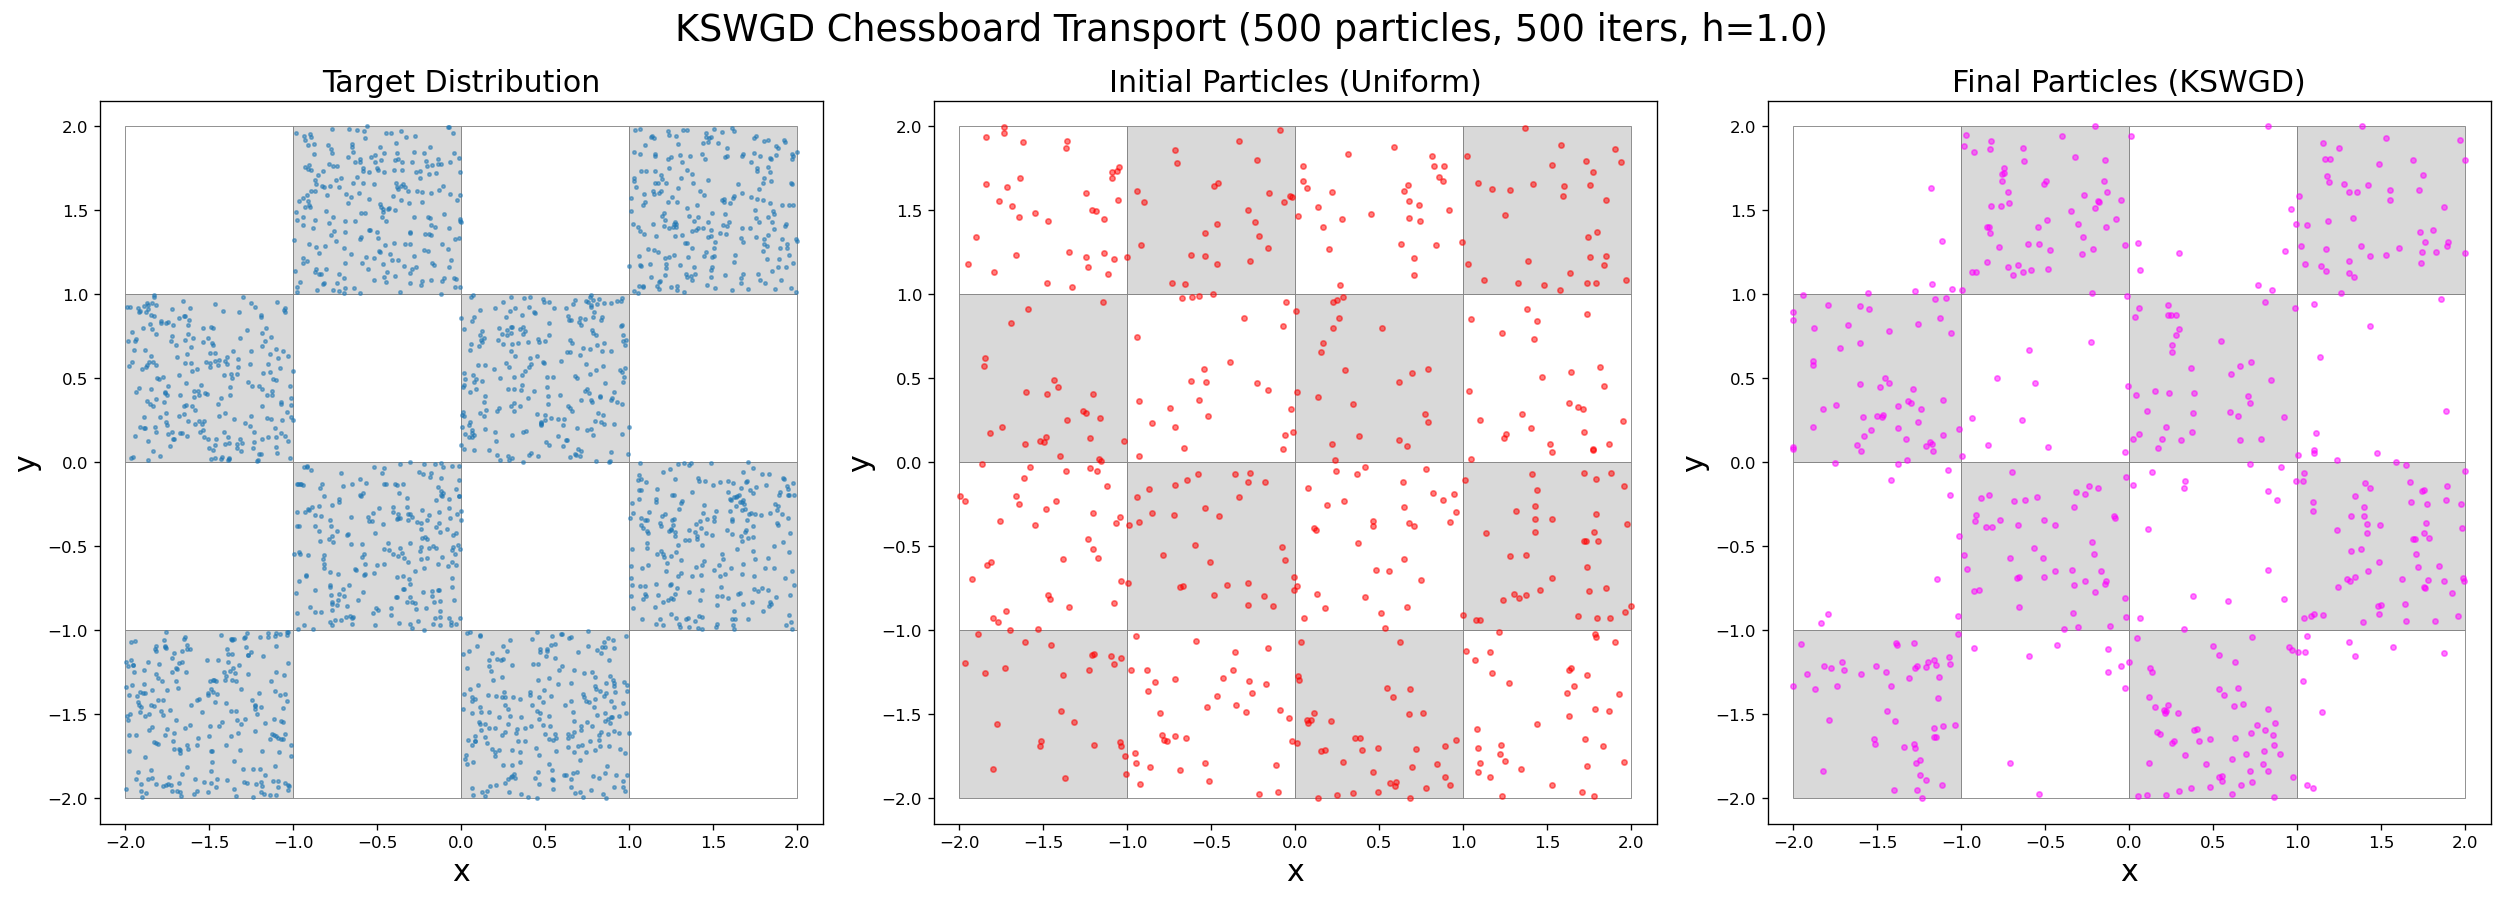


[RESULT] 414/500 particles (82.8%) ended in gray squares


In [53]:
# === Side-by-side: Target, Initial, Final ===
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

titles = ['Target Distribution', 'Initial Particles (Uniform)', 'Final Particles (KSWGD)']
data_list = [X_tar, x_snapshots[0], x_final]
colors_list = ['C0', 'red', 'magenta']
sizes = [4, 10, 10]

for ax_idx in range(3):
    ax = axes[ax_idx]
    draw_chessboard(ax)
    ax.scatter(data_list[ax_idx][:, 0], data_list[ax_idx][:, 1],
               s=sizes[ax_idx], c=colors_list[ax_idx], alpha=0.5, zorder=2)
    ax.set_title(titles[ax_idx], fontsize=18)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)

plt.suptitle(f'KSWGD Chessboard Transport ({m_particles} particles, {num_iters} iters, h={step_size})',
             fontsize=22, y=1.02)
plt.tight_layout()
plt.show()

# === Quantitative: fraction of final particles in gray squares ===
final_in_gray = np.zeros(m_particles, dtype=bool)
for idx in range(num_gray):
    x_lo, y_lo, x_hi, y_hi = square_bounds[idx]
    inside = ((x_final[:, 0] >= x_lo) & (x_final[:, 0] <= x_hi) &
              (x_final[:, 1] >= y_lo) & (x_final[:, 1] <= y_hi))
    final_in_gray |= inside
pct = 100.0 * np.sum(final_in_gray) / m_particles
print(f"\n[RESULT] {np.sum(final_in_gray)}/{m_particles} particles ({pct:.1f}%) ended in gray squares")

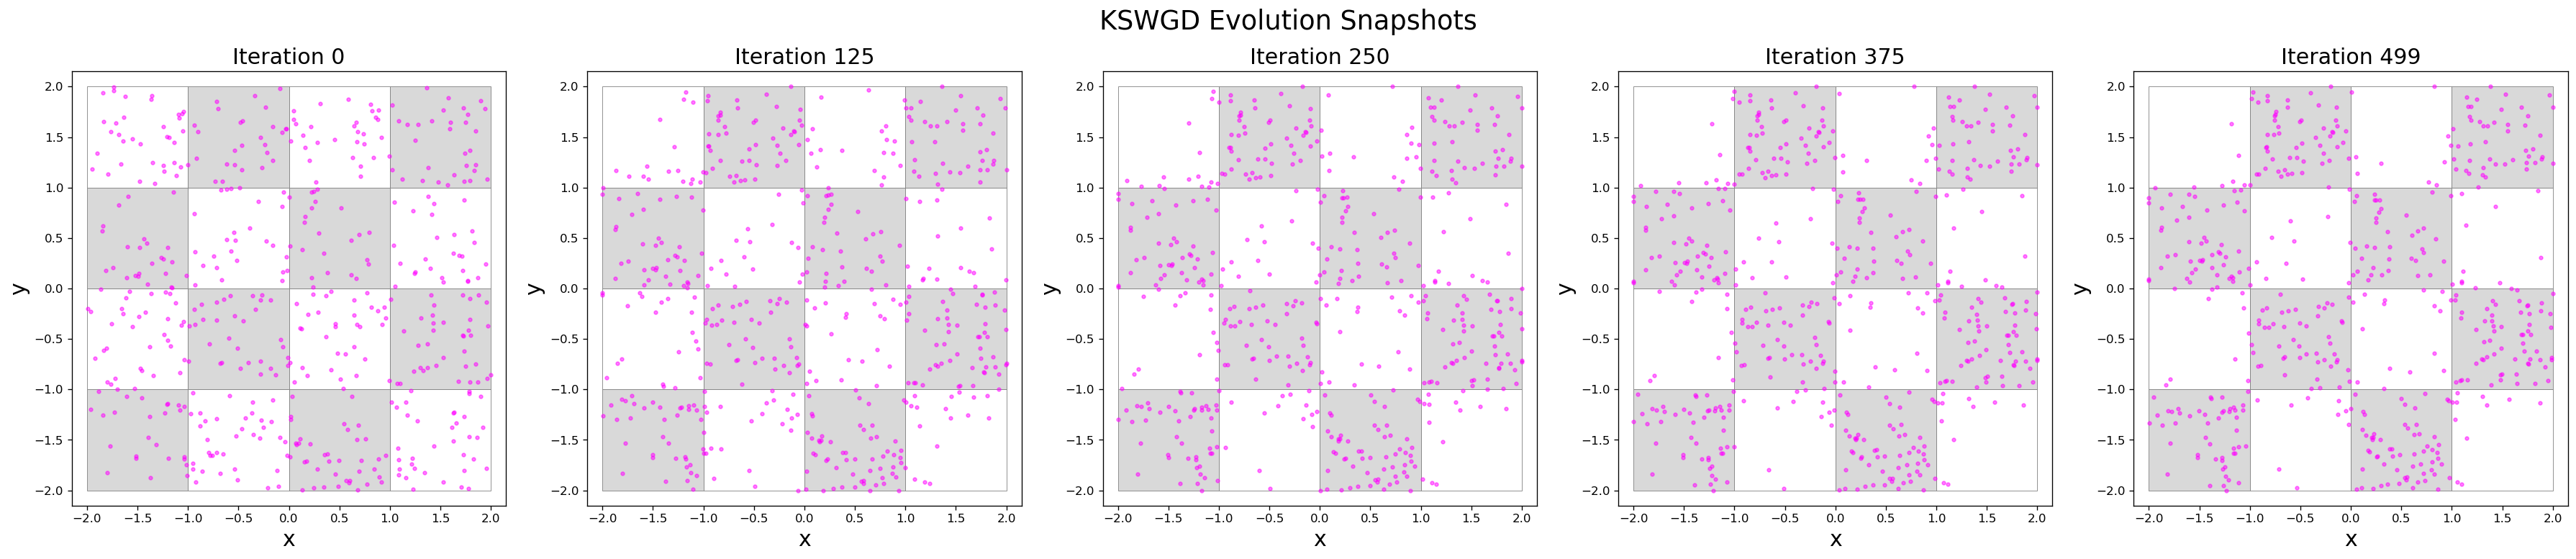

In [52]:
# === Evolution snapshots ===
snap_keys = sorted(x_snapshots.keys())
n_snaps = len(snap_keys)
fig, axes = plt.subplots(1, n_snaps, figsize=(6 * n_snaps, 6))
if n_snaps == 1:
    axes = [axes]

for ax, key in zip(axes, snap_keys):
    draw_chessboard(ax)
    ax.scatter(x_snapshots[key][:, 0], x_snapshots[key][:, 1],
               s=8, c='magenta', alpha=0.5, zorder=2)
    ax.set_title(f'Iteration {key}', fontsize=18)
    ax.set_xlabel('x', fontsize=18); ax.set_ylabel('y', fontsize=18)

plt.suptitle('KSWGD Evolution Snapshots', fontsize=22, y=1.02)
plt.tight_layout()
plt.show()

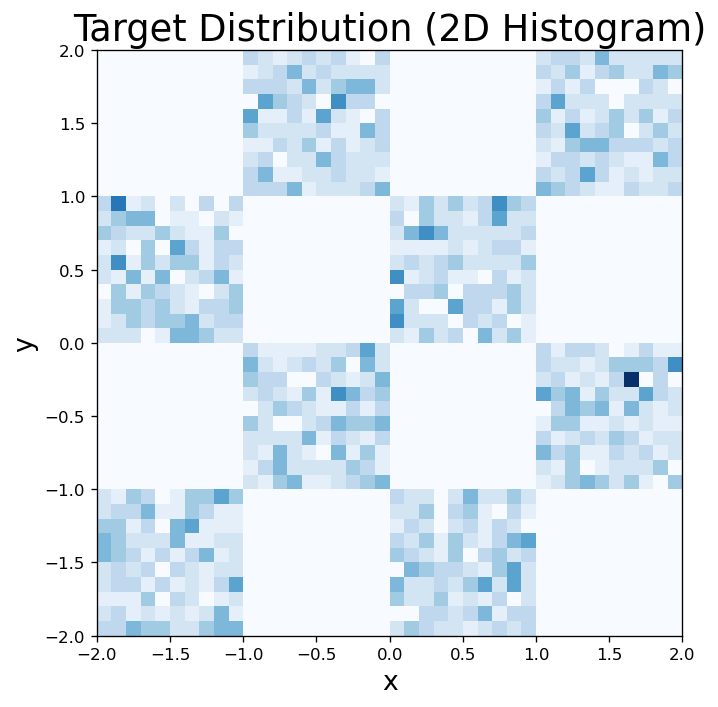

In [49]:
# === 2D Histogram: Target Distribution ===
bins = np.linspace(DOMAIN_LO, DOMAIN_HI, 41)

fig, ax = plt.subplots(figsize=(7, 6))
ax.hist2d(X_tar[:, 0], X_tar[:, 1], bins=bins, cmap='Blues', density=True)
ax.set_title('Target Distribution (2D Histogram)', fontsize=22)
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16); ax.set_ylabel('y', fontsize=16)
plt.tight_layout()
plt.show()

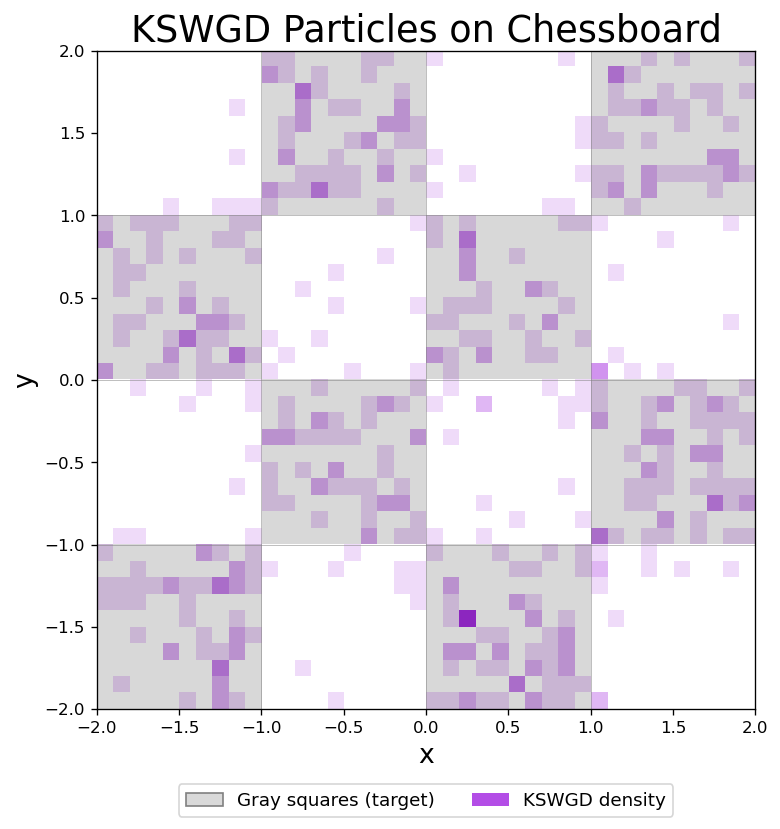

In [50]:
# === 2D Histogram: KSWGD Particles on Chessboard ===
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(7, 7))

# Compute 2D histogram for KSWGD final particles
H_fin, xedges, yedges = np.histogram2d(x_final[:, 0], x_final[:, 1], bins=bins, density=True)
H_fin_norm = H_fin / (H_fin.max() + 1e-12)

# Build chessboard mask: 1 where gray, 0 where white
chess_mask = np.zeros_like(H_fin_norm)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
for ix, xc in enumerate(x_centers):
    for iy, yc in enumerate(y_centers):
        gi = int((xc - DOMAIN_LO) / SPACING)
        gj = int((yc - DOMAIN_LO) / SPACING)
        gi = min(gi, GRID_SIZE - 1)
        gj = min(gj, GRID_SIZE - 1)
        if (gi + gj) % 2 == 0:
            chess_mask[ix, iy] = 1.0

# RGB: gray squares = light gray, KSWGD density = purple overlay, white squares stay white
rgb = np.ones((H_fin_norm.shape[0], H_fin_norm.shape[1], 3))
# Gray squares background
rgb[:, :, 0] -= chess_mask * 0.15
rgb[:, :, 1] -= chess_mask * 0.15
rgb[:, :, 2] -= chess_mask * 0.15
# KSWGD particles: magenta/purple tint
rgb[:, :, 0] -= H_fin_norm * 0.3
rgb[:, :, 1] -= H_fin_norm * 0.7
rgb[:, :, 2] -= H_fin_norm * 0.1
rgb = np.clip(rgb, 0, 1)

rgb_display = np.transpose(rgb, (1, 0, 2))[::-1]
ax.imshow(rgb_display, extent=[DOMAIN_LO, DOMAIN_HI, DOMAIN_LO, DOMAIN_HI], aspect='equal')

# Grid lines
for k in range(GRID_SIZE + 1):
    coord = DOMAIN_LO + k * SPACING
    ax.axhline(coord, color='gray', linewidth=0.5, alpha=0.6)
    ax.axvline(coord, color='gray', linewidth=0.5, alpha=0.6)

ax.set_title('KSWGD Particles on Chessboard', fontsize=22)
ax.set_xlabel('x', fontsize=16); ax.set_ylabel('y', fontsize=16)

# Legend below the plot, horizontal
legend_elements = [
    Patch(facecolor=(0.85, 0.85, 0.85), edgecolor='gray', label='Gray squares (target)'),
    Patch(facecolor=(0.7, 0.3, 0.9), label='KSWGD density'),
]
ax.legend(handles=legend_elements, fontsize=11, loc='upper center',
          bbox_to_anchor=(0.5, -0.10), ncol=2, frameon=True)
plt.tight_layout()
plt.show()

In [37]:
# === Per-square occupancy analysis ===
print("Per-square particle counts (final):")
print(f"{'Square':>10} | {'x range':>16} | {'y range':>16} | {'Count':>6} | {'Expected':>8}")
print("-" * 70)

expected_per_square = m_particles / num_gray
for idx in range(num_gray):
    x_lo, y_lo, x_hi, y_hi = square_bounds[idx]
    inside = ((x_final[:, 0] >= x_lo) & (x_final[:, 0] <= x_hi) &
              (x_final[:, 1] >= y_lo) & (x_final[:, 1] <= y_hi))
    count = np.sum(inside)
    print(f"  Gray {idx:2d}  | [{x_lo:5.1f}, {x_hi:5.1f}]   | [{y_lo:5.1f}, {y_hi:5.1f}]   | {count:5d}  | {expected_per_square:7.1f}")

# Count particles in white squares
white_count = m_particles - np.sum(final_in_gray)
print(f"\nParticles in white squares: {white_count} ({100*white_count/m_particles:.1f}%)")
print(f"Particles in gray squares:  {np.sum(final_in_gray)} ({pct:.1f}%)")

Per-square particle counts (final):
    Square |          x range |          y range |  Count | Expected
----------------------------------------------------------------------
  Gray  0  | [ -2.0,  -1.0]   | [ -2.0,  -1.0]   |    50  |    62.5
  Gray  1  | [ -2.0,  -1.0]   | [  0.0,   1.0]   |    51  |    62.5
  Gray  2  | [ -1.0,   0.0]   | [ -1.0,   0.0]   |    49  |    62.5
  Gray  3  | [ -1.0,   0.0]   | [  1.0,   2.0]   |    56  |    62.5
  Gray  4  | [  0.0,   1.0]   | [ -2.0,  -1.0]   |    61  |    62.5
  Gray  5  | [  0.0,   1.0]   | [  0.0,   1.0]   |    38  |    62.5
  Gray  6  | [  1.0,   2.0]   | [ -1.0,   0.0]   |    62  |    62.5
  Gray  7  | [  1.0,   2.0]   | [  1.0,   2.0]   |    47  |    62.5

Particles in white squares: 86 (17.2%)
Particles in gray squares:  414 (82.8%)


## 5. Eigenvalue Spectrum Analysis

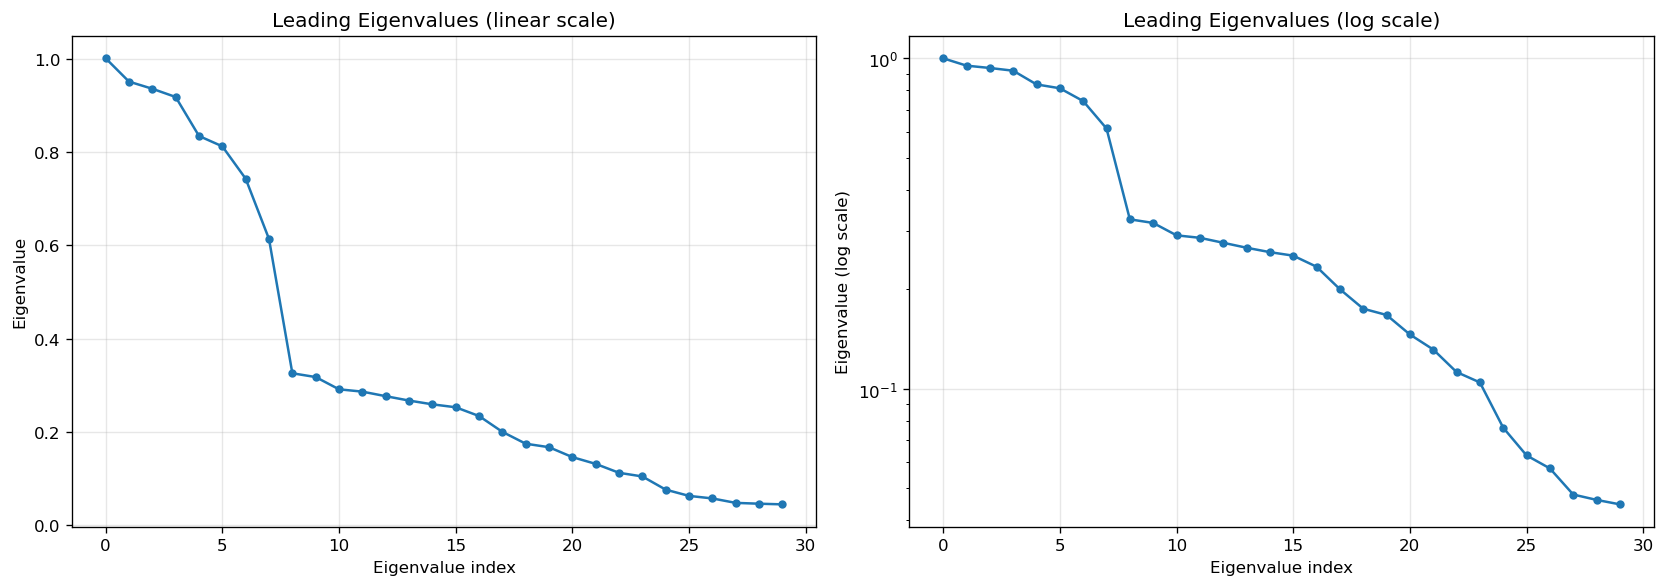

First 10 eigenvalues: [1.000612 0.950658 0.935316 0.917677 0.834117 0.811905 0.742556 0.613343
 0.325571 0.317477]


In [38]:
# Plot eigenvalue decay
n_show_eigs = min(30, len(lambda_ns))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(n_show_eigs), lambda_ns[:n_show_eigs], 'o-', markersize=4)
axes[0].set_xlabel('Eigenvalue index')
axes[0].set_ylabel('Eigenvalue')
axes[0].set_title('Leading Eigenvalues (linear scale)')
axes[0].grid(True, alpha=0.3)

positive_eigs = lambda_ns[lambda_ns > 0]
axes[1].semilogy(range(min(n_show_eigs, len(positive_eigs))),
                 positive_eigs[:n_show_eigs], 'o-', markersize=4)
axes[1].set_xlabel('Eigenvalue index')
axes[1].set_ylabel('Eigenvalue (log scale)')
axes[1].set_title('Leading Eigenvalues (log scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"First 10 eigenvalues: {lambda_ns[:10].round(6)}")